### Setup


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from etna.datasets import TSDataset
from etna.models import NaiveModel, CatBoostPerSegmentModel
from etna.metrics import SMAPE
from etna.analysis import plot_forecast, plot_backtest
from etna.transforms import LagTransform, LogTransform
from etna.pipeline import Pipeline, FoldMask

import warnings
from IPython.display import clear_output

plt.rcParams["figure.figsize"] = (7, 3)
plt.rcParams["grid.alpha"] = 0.25
warnings.filterwarnings("ignore")
clear_output()

### Reading data


In [2]:
df_origin = pd.read_csv(
    "../data/taxi.csv", parse_dates=["datetime"], index_col="datetime")
df_origin.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# resample the data to 1 hour interval
df_origin = df_origin.resample("1H").sum()
df_origin.reset_index(inplace=True)

In [4]:
df_origin["timestamp"] = pd.to_datetime(df_origin["datetime"])
df_origin["target"] = df_origin["num_orders"]
df_origin = df_origin[["timestamp", "target"]]
df_origin["segment"] = "Number of Taxi Orders"

df_origin.head()

,timestamp,target,segment
0,2018-03-01 00:00:00,124,Number of Taxi Orders
1,2018-03-01 01:00:00,85,Number of Taxi Orders
2,2018-03-01 02:00:00,71,Number of Taxi Orders
3,2018-03-01 03:00:00,66,Number of Taxi Orders
4,2018-03-01 04:00:00,43,Number of Taxi Orders


In [5]:
df = TSDataset.to_dataset(df_origin)
ts = TSDataset(df, freq="H")

### Pipeline


In [6]:
# take only one month for now
ts = TSDataset(ts["2018-03-01":"2018-05-31"], freq="H")

train_ts, test_ts = ts.train_test_split(
    train_start="2018-03-01",
    train_end="2018-05-30",
    test_start="2018-05-31",
    test_end="2018-05-31"
)

In [7]:
HORIZON = 24

transforms = [
    LagTransform(in_column="target", lags=[HORIZON * i for i in range(1, 6)]),
    LogTransform(in_column="target")
]

In [8]:
pipeline = Pipeline(
    model=CatBoostPerSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
)

pipeline.fit(train_ts)
forecast_ts = pipeline.forecast()

In [9]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'Number of Taxi Orders': 17.07032637771686}

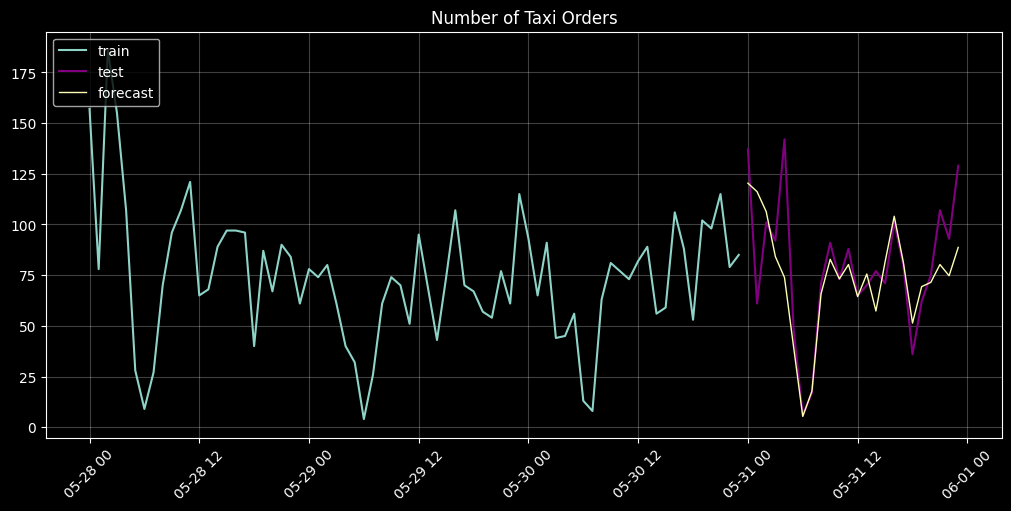

In [10]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=HORIZON*3)

### ExpandingWindowSplitter


In [11]:
metrics_df, *_ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=3, mode="expand"
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


In [12]:
metrics_df

,segment,SMAPE,fold_number
0,Number of Taxi Orders,33.190472,0
0,Number of Taxi Orders,28.419928,1
0,Number of Taxi Orders,17.070326,2


### Single window splitter


In [13]:
# without mask
metrics_df, *_ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=1,
)
clear_output()
metrics_df

,segment,SMAPE,fold_number
0,Number of Taxi Orders,17.070326,0


In [14]:
ts.index.max()

Timestamp('2018-05-31 23:00:00', freq='H')

In [15]:
# with a specific mask
window_size = HORIZON * 91
first_train_ts = ts.index.min()
last_train_ts = first_train_ts + np.timedelta64(window_size - 1, "h")
target_ts = pd.date_range(start=last_train_ts +
                          np.timedelta64(1, "h"), periods=HORIZON, freq="h")
mask = FoldMask(
    first_train_timestamp=first_train_ts,
    last_train_timestamp=last_train_ts,
    target_timestamps=target_ts,
)

print(first_train_ts)
print(last_train_ts)
print(target_ts)

2018-03-01 00:00:00
2018-05-30 23:00:00
DatetimeIndex(['2018-05-31 00:00:00', '2018-05-31 01:00:00',
               '2018-05-31 02:00:00', '2018-05-31 03:00:00',
               '2018-05-31 04:00:00', '2018-05-31 05:00:00',
               '2018-05-31 06:00:00', '2018-05-31 07:00:00',
               '2018-05-31 08:00:00', '2018-05-31 09:00:00',
               '2018-05-31 10:00:00', '2018-05-31 11:00:00',
               '2018-05-31 12:00:00', '2018-05-31 13:00:00',
               '2018-05-31 14:00:00', '2018-05-31 15:00:00',
               '2018-05-31 16:00:00', '2018-05-31 17:00:00',
               '2018-05-31 18:00:00', '2018-05-31 19:00:00',
               '2018-05-31 20:00:00', '2018-05-31 21:00:00',
               '2018-05-31 22:00:00', '2018-05-31 23:00:00'],
              dtype='datetime64[ns]', freq='H')


In [16]:
metrics_df, forecast_df, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=[mask])
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


,segment,SMAPE,fold_number
0,Number of Taxi Orders,17.070326,0


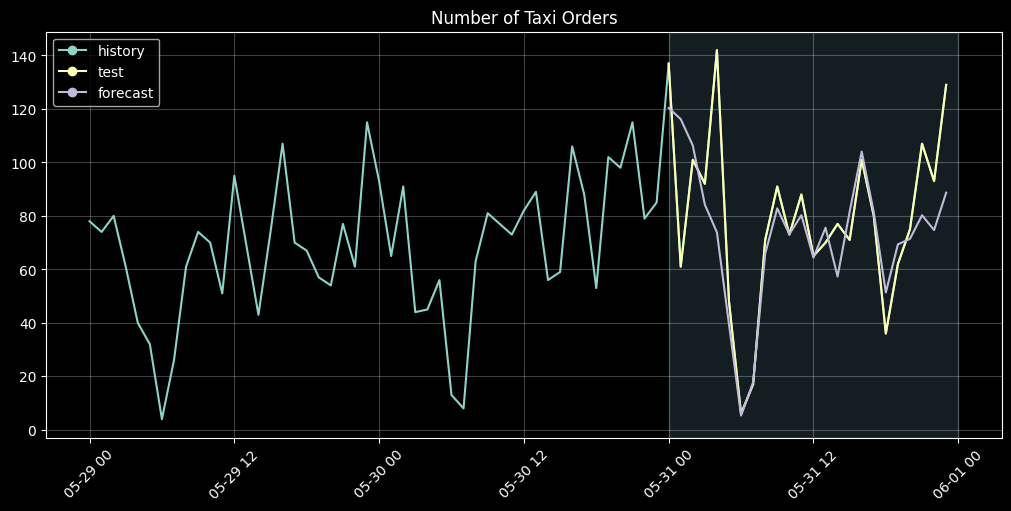

In [17]:
plot_backtest(forecast_df, ts, history_len=HORIZON*2)

### Sliding window splitter


In [18]:
ts.index.__len__() / HORIZON

92.0

In [19]:
83 * HORIZON
ts.index.__len__() - 3 * HORIZON * 3

1992

In [20]:
def sliding_window_splitter(window_size: int = 2, n_folds: int = 3):
  masks = []
  window_size *= HORIZON
  training_size = ts.index.__len__() - n_folds * window_size - HORIZON
  for n in range(n_folds):

    first_train_ts = ts.index.min() + np.timedelta64(n * window_size, "h")
    last_train_ts = first_train_ts + np.timedelta64(training_size, "h") + \
        np.timedelta64(window_size - 1, "h")
    target_ts = pd.date_range(start=last_train_ts +
                              np.timedelta64(1, "h"), periods=HORIZON, freq="h")
    mask = FoldMask(
        first_train_timestamp=first_train_ts,
        last_train_timestamp=last_train_ts,
        target_timestamps=target_ts,
    )
    masks.append(mask)
  return masks

In [21]:
masks = sliding_window_splitter()
metrics_df, forecast_df, _ = pipeline.backtest(
    ts=ts, metrics=[SMAPE()], n_folds=masks
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


In [22]:
ts.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

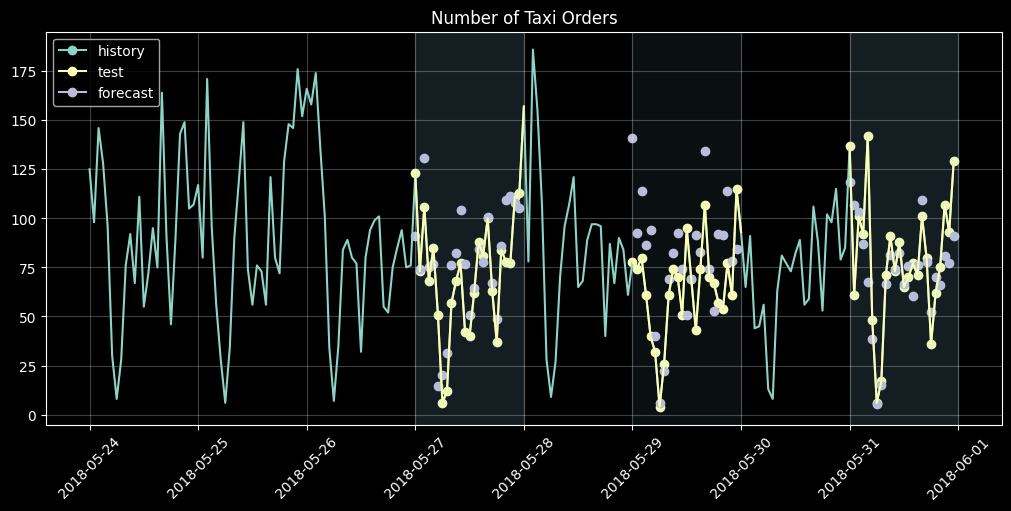

In [23]:
plot_backtest(forecast_df, ts, history_len=HORIZON*3)

### Apply more transforms
